In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob

In [3]:
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack, unique
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget              import  targetmask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations
from    desisurvey.utils        import  get_date

In [4]:
##  DR7 cutouts
import  requests

from    PIL                     import  Image
from    io                      import  BytesIO

In [7]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0) + 0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return  mag

##  DR7 cutouts 

In [10]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

In [11]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
version = 'v2'
root    = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/{}/'.format(version)

## Prep. redrock templates

In [12]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [13]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [14]:
# Table(LGAMA)

In [15]:
# Table(GAMA)

In [16]:
# plt.rcParams['figure.figsize'] = [10, 10]
# pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [17]:
##  Restrict to G12
isin = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12  =   GAMA[isin]
LG12 =  LGAMA[isin]

In [18]:
# plt.rcParams['figure.figsize'] = [10, 10]
# pl.plot(G12['RA'], G12['DEC'], '.')

##  GET SDSS redshifts  

In [19]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Aaron's GFA Telemetry

In [20]:
file      = fits.open('/global/cfs/cdirs/desi/users/ameisner/GFA/minisv2/gfa_reduce_ccds_minisv2-thru_20200304.fits')
# file[1].header

In [21]:
# Takes a while for NIGHT computation.
telemetry = Table(file[1].data)  
original  = telemetry.columns

keep_cols = ['CAMERA', 'EXPID', 'MJD', 'PROGRAM', 'SKY_MAG_AB', 'PETAL_LOC',\
             'MOONRA', 'MOONDEC', 'AIRMASS', 'FIBER_FRACFLUX',\
             'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

# telemetry = telemetry[keep_cols]

# telemetry.sort('PETAL_LOC')

# telemetry['EXPID'] += 1 
# telemetry

In [22]:
uprogs, cnts = np.unique(telemetry['PROGRAM'], return_counts=True)

progs2keep   = ['MW tile 70500',\
                'MW tile 70510',\
                'MW+BGS tile 70500 (1 of 2)',\
                'MW/BGS tile 70502 (1 of 2)',\
                'MW/BGS tile 70510',\
                'MW/BGS tile 70510 (1 of 2)',\
                'SV tile 70502',\
                #'Commissioning',\
               ]

keep         = [x.strip() in progs2keep for x in telemetry['PROGRAM']]

for i, x in enumerate(uprogs):
  this       = np.array(telemetry['PROGRAM'])[keep]   

  if np.any(this == x):      
    print('{:2d}  {} {} \t {}'.format(i, repr(x), cnts[i], np.any(this == x)))
    
  else:    
    print('{:2d}  {} {} \t \t {}'.format(i, repr(x), cnts[i], np.any(this == x)))

 0  'Commissioning                                                                                 ' 222 	 	 False
 1  'Dither fibermode tile 63159 (106.34, 31.89)                                                   ' 144 	 	 False
 2  'Dither fibermode tile 63160 (106.34, 31.89)                                                   ' 144 	 	 False
 3  'Dither fibermode tile 63161 (106.34, 31.89)                                                   ' 144 	 	 False
 4  'Dither fibermode tile 63162 (106.34, 31.89)                                                   ' 144 	 	 False
 5  'Dither fibermode tile 63163 (106.34, 31.89)                                                   ' 144 	 	 False
 6  'Dither fibermode tile 63164 (106.34, 31.89)                                                   ' 144 	 	 False
 7  'Dither fibermode tile 63165 (106.34, 31.89)                                                   ' 144 	 	 False
 8  'Dither fibermode tile 63166 (106.34, 31.89)                                

In [23]:
# np.any(telemetry['EXPID'] == 52448)

In [24]:
bgs_telemetry = telemetry[keep]
bgs_telemetry

MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,CAMERA,SKY_MAG_AB,SKY_MAG_AB_PER_AMP [4],PETAL_LOC,EXPID,MJD,PROGRAM,SKYRA,SKYDEC,DOMSHUTL,DOMSHUTU,PMCOVER,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,AIRMASS,NIGHT,FOCUS,EXPTIME,CUBE_INDEX,RACEN,DECCEN,FNAME_RAW,GITREV,EXTNAME,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP [4],OVERSCAN_MEDIANS_ADU [4],PRESCAN_MEDIANS_ADU [4],FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],FNAME_MASTER_DARK,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP [4],DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS [4],DARK_RESCALE_CONVERGED [4]
float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str6,float64,float32,uint8,int64,float64,str94,float64,float64,str8,str8,str4,float64,float64,float64,int64,float64,float64,int64,str37,float64,int64,float64,float64,str97,str7,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,str8,float64,float64,float64,str114,uint8,float64,float64,float64,float64,float64,float64,float64,uint8,int64,uint8
1684.0,1693.462463852047,0,32392.0,1541.0,44.47806655516806,44.47806655516806,1695.0,1706.4587875484497,0,11531.0,1574.0,42.99546433666246,42.99546433666246,1643.0,1654.2313412215358,0,22821.0,1541.0,32.61724880712325,32.61724880712325,1686.0,1698.5380178052326,0,23036.0,1582.0,37.06505546264005,37.06505546264005,1702.0,1714.62170883297,0,32392.0,1597.0,40.030259899651256,40.030259899651256,GUIDE0,21.006675233518607,21.017637 .. 21.016413,0,52090,58905.25448622,SV tile 70502,180.012,-0.510261,not open,open,open,6.887381,-2.523766,9.678,0,15.0,1.663456,20200225,"617.4,-264.2,1076.3,-18.4,-2.1,0.0",15.0,0,179.58462698957734,-2.031037823124222,/project/projectdirs/desi/spectro/data/20200225/00052090/guide-00052090.fits.fz,1f12aa8,GUIDE0,3.8204875294661815,0.09543107532242492,6,0.33568707637040507,26.011779427199414,25.280014697547998,171.3949218890838,25.40374320807157,0.8223710859427306,0,0 .. 0,1434.0 .. 1395.0,1419.0 .. 1384.0,24.78859683568296,12.59709429145485,17.671001434326172,3.622555294036865,18,2048 .. 1032,-5.64158190288e-05 .. 5.1670258812e-05,1.0 .. 1.0,2241.951981159889 .. 29530.036653755775,180.012 .. -0.510261,RA---TAN .. DEC--TAN,180.0,90.0,0.0 .. 0.0,/project/projectdirs/desi/users/ameisner/GFA/gfa_reduce_etc/master_dark_library/master_dark-00034652_00034751.fits,1,15.0,9.918,0.9294595855618852,14.560446187674744,1.0384375000000001 .. 1.0432012939453128,1.0443664550781253,1.0443664550781253,1,27 .. 41,1 .. 1
1503.0,1480.81327358512,0,32781.0,1251.0,103.78215529539214,103.78215529539214,1526.0,1528.935664213905,0,14813.0,1433.0,14.82602218505602,14.82602218505602,1463.0,1468.0797317859738,0,32781.0,1345.0,14.82602218505602,14.82602218505602,1598.0,1601.1597777374031,0,21055.0,1531.0,16.308624403561623,16.308624403561623,1321.0,1325.0779206031978,0,25193.0,1251.0,16.308624403561623,16.308624403561623,GUIDE2,21.130802625301424,21.133589 .. 21.107409,2,52090,58905.25448622,SV tile 70502,180.012,-0.510261,not open,open,open,6.887381,-2.523766,9.739,0,15.0,1.663456,20200225,"617.4,-264.2,10

In [408]:
#np.any(telemetry['EXPID'] == 52090)

In [409]:
uexpids     = np.unique(bgs_telemetry['EXPID'])
# np.sort(uexpids)

In [411]:
#  Average over petals and available sub-exposures (MJD).
first_exp = bgs_telemetry[(bgs_telemetry['EXPID'] == uexpids[0])]

keys      = bgs_telemetry.keys()
keys.sort()
keys      = list(keys)

for key in keys:
  if  np.all(first_exp[key][:] == first_exp[key][0]):   
    print('{} \t {}'.format(key.ljust(25), True))
    
  else:
    print('{} \t \t {} \t \t {}'.format(key.ljust(25), False, len(np.unique(first_exp[key][:]))))

AIRMASS                   	 True
APER_CORR_FAC             	 	 False 	 	 642
APPLY_DARK_RESCALE_FACTOR 	 True
CAMERA                    	 	 False 	 	 6
CD                        	 	 False 	 	 24
CDELT                     	 True
CONTRAST                  	 	 False 	 	 632
CRPIX                     	 	 False 	 	 1158
CRVAL                     	 True
CTYPE                     	 True
CUBE_INDEX                	 	 False 	 	 107
DARK_RESCALE_CONVERGED    	 True
DARK_RESCALE_FACTORS_PER_AMP 	 	 False 	 	 2310
DARK_RESCALE_FACTOR_ADOPTED 	 	 False 	 	 638
DARK_RESCALE_FACTOR_BESTFIT 	 	 False 	 	 638
DARK_RESCALE_NCALLS       	 	 False 	 	 36
DARK_TEMP_SCALING_FACTOR  	 	 False 	 	 74
DECCEN                    	 	 False 	 	 637
DOMSHUTL                  	 True
DOMSHUTU                  	 True
DO_FIT_DARK_SCALING       	 True
EXPID                     	 True
EXPTIME                   	 	 False 	 	 2
EXTNAME                   	 	 False 	 	 6
FIBER_FRACFLUX            	 	 False 	 	 642
FNAME_MAST

In [412]:
mean = Table()
row  = Table()

keys = list(bgs_telemetry.columns)

for i, expid in enumerate(uexpids):
  #  Average over petals and available sub-exposures (MJD).
  this_exp = bgs_telemetry[(bgs_telemetry['EXPID'] == expid)]

  # if i % 1 == 0:
  #   print('Solving for id {} ({}%).'.format(expid, 100. * np.float(i) / len(uexpids)))
    
  for key in keys:
    try:
      if key == 'EXPID':
        row[key] = np.array(this_exp[key].mean(), dtype  = '>i8')
        
      elif key in ['NIGHT', 'TILEID']:
        row[key] = np.array([this_exp[key].mean()] * len(this_exp))
        
      else:
        row[key] = np.atleast_1d(np.median(this_exp[key][~np.isnan(this_exp[key])]))
        
    except:
      if i == 0:
        print('\tFailed to add {} \t {} \t {}.'.format(key.ljust(15), 0.0, str(this_exp[key].dtype)))  
 
  mean = vstack((row, mean))

mean['NIGHT']  = [get_date(x) for x in mean['MJD']]
# mean

	Failed to add CAMERA          	 0.0 	 <U6.
	Failed to add PROGRAM         	 0.0 	 <U94.
	Failed to add DOMSHUTL        	 0.0 	 <U8.
	Failed to add DOMSHUTU        	 0.0 	 <U8.
	Failed to add PMCOVER         	 0.0 	 <U4.
	Failed to add NIGHT           	 0.0 	 >i8.
	Failed to add FOCUS           	 0.0 	 <U37.
	Failed to add FNAME_RAW       	 0.0 	 <U97.
	Failed to add GITREV          	 0.0 	 <U7.
	Failed to add EXTNAME         	 0.0 	 <U6.
	Failed to add CTYPE           	 0.0 	 <U8.
	Failed to add FNAME_MASTER_DARK 	 0.0 	 <U114.


In [413]:
mean.sort('MJD')

toprint = mean['NIGHT', 'MJD', 'EXPID', 'TRANSPARENCY']
toprint.pprint(max_lines=-1)

  NIGHT           MJD         EXPID     TRANSPARENCY   
---------- ------------------ ----- -------------------
2020-02-25       58905.261031 52090  0.9329016901707361
2020-02-25     58905.29986755 52112  0.9224806856783989
2020-02-25     58905.31607697 52113  0.9098586913547361
2020-02-25       58905.331858 52114  0.9039163076847865
2020-02-25    58905.346548945 52115  0.8896225398313252
2020-02-25    58905.361891895 52116  0.8929896669366592
2020-02-27    58907.375137015 52445 0.20901249699527769
2020-02-27     58907.39256414 52447 0.13970091435190415
2020-02-27 58907.417336315004 52462  0.1433521610472111
2020-02-28    58908.172101585 52628 0.35128697772973816
2020-02-28     58908.18487546 52630  0.0943670604751155
2020-02-28     58908.23741972 52636 0.15588020348323087
2020-02-29    58909.279073345 52790 0.10314137257563905
2020-03-03    58912.279591935 52932  0.9304259523400431
2020-03-03     58912.29585026 52934  0.9361679903055249
2020-03-03      58912.3121503 52936  0.930881971

In [30]:
# for x in mean.columns:
#    print(x)

##  Rongpu cframe Table 

In [414]:
# ALL EXPIDS
cpath      = '/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_{}.fits'.format(version)
cframes    = Table(fits.open(cpath)[1].data)

del  cframes['cframe']

cols       = list(cframes.columns)

for x in cols:
  cframes.rename_column(x, x.upper())

new       = mean.columns
keep      = [x not in cframes.columns for x in new]  
  
new       = ['EXPID'] + [x for i, x in enumerate(new) if keep[i]]

cframes   = join(cframes, mean[new], keys='EXPID', join_type='left')

keep      = (cframes['CAMERA'] == 'b') & (cframes['PETAL_LOC'] == 0)

cframes   =  cframes[keep]

cframes.sort('NIGHT')
cframes

NIGHT,MJD,LAT,LON,ELV,TILEID,EXPID,EXPTIME,CAMERA,PETAL_LOC,RA,DEC,MOON_ALT,MOON_RA,MOON_DEC,MOON_FRAC,MOON_SEP,SUN_ALT,SUN_RA,SUN_DEC,SUN_SEP,MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,SKY_MAG_AB,SKY_MAG_AB_PER_AMP,SKYRA,SKYDEC,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,AIRMASS,CUBE_INDEX,RACEN,DECCEN,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP,OVERSCAN_MEDIANS_ADU,PRESCAN_MEDIANS_ADU,FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS,CD,CDELT,CRPIX,CRVAL,LONGPOLE,LATPOLE,PV2,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP,DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS,DARK_RESCALE_CONVERGED
str8,float64,float64,float64,float64,int64,int64,float64,str1,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,31.96403,-111.59989,2097.0,70502,52090,900.0,b,0,180.012,-0.510261,-34.718479928578454,6.5807555865875145,-2.851443373246277,0.0627905403740725,172.62306389652935,-58.98578687979692,338.81845580446975,-8.902828361677603,156.884725513756,1519.0,1510.7284583749697,0.0,14182.5,1341.0,77.0953153622913,77.0953153622913,1535.0,1536.4808037336484,0.0,6824.5,1439.0,10.378215529539215,10.378215529539215,1473.5,1480.3039323673693,0.0,13831.5,1390.5,11.119516638792016,11.119516638792016,1530.0,1533.8316328654919,0.0,7970.0,1438.0,13.343419966550417,13.343419966550417,1425.0,1432.4922423843266,0.0,8167.5,1341.0,11.860817748044816,11.860817748044816,21.156048952702427,21.146492,180.012,-0.510261,6.887381,-2.523766,9.635,0.0,5.0,1.663456,53.0,179.99848173849458,-0.5499444522887729,3.704286245102063,0.15167707898927107,4.0,0.46982766066365306,24.866301812622293,24.89151397914012,172.36074296971404,25.491082369608563,0.9329016901707361,0.0,0.0,1407.0,1394.0,13.13873412399685,11.439420193512799,12.233884811401367,2.50794638633728,11.0,1540.0,2.0343276314399996e-08,1.0,15989.204029229637,89.7508695,180.0,90.0,0.0,1.0,5.0,10.07,0.8863985113368575,4.694805858494657,1.050155029296875,1.050855712890625,1.050855712890625,1.0,36.0,1.0
20200225,58905.29573492,31.96403,-111.59989,2097.0,70502,52112,900.0,b,0,180.006929,-0.50838,-44.78365842537352,7.1329206177420295,-2.665919591058877,0.06456711009394417,172.20096734808536,-65.6478509433898,338.855669375522,-8.888320132355824,156.92963243536897,1520.0,1512.220562365628,0.0,15085.5,1344.5,76.35401425303851,76.35401425303851,1536.0,1537.4314390670422,0.0,6892.0,1442.0,10.378215529539215,10.378215529539215,1474.5,1481.374058449915,0.0,14309.0,1393.5,11.860817748044816,11.860817748044816,1532.0,1535.875820426054,0.0,8398.0,1442.0,13.343419966550417,13.343419966550417,1425.5,1433.454674062803,0.0,9092.5,1344.5,11.860817748044816,11.860817748044816,21.2015594820708,21.18658,180.006929,-0.50838,7.309801,-2.342021

In [415]:
cpath

'/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_v2.fits'

In [416]:
toprint = cframes['NIGHT', 'MJD', 'EXPID', 'TRANSPARENCY', 'MOON_RA', 'MOONRA', 'MOON_DEC', 'MOONDEC', 'MOON_SEP', 'MOON_SEP_DEG']
toprint.pprint(max_lines=-1, max_width=-1)

 NIGHT        MJD       EXPID     TRANSPARENCY         MOON_RA         MOONRA        MOON_DEC       MOONDEC       MOON_SEP         MOON_SEP_DEG   
-------- -------------- ----- ------------------- ------------------ --------- ------------------- --------- ------------------ ------------------
20200225 58905.25690431 52090  0.9329016901707361 6.5807555865875145  6.887381  -2.851443373246277 -2.523766 172.62306389652935 172.36074296971404
20200225 58905.29573492 52112  0.9224806856783989 7.1329206177420295  7.309801  -2.665919591058877 -2.342021 172.20096734808536 172.09644831795063
20200225 58905.31193004 52113  0.9098586913547361  7.370947675013313  7.483259  -2.589179006361515 -2.267338 172.01170605260654 171.94704345209988
20200225 58905.32773044 52114  0.9039163076847865  7.606742043392503  7.656684  -2.514662923499652  -2.19264  171.8204720353583 171.79637620586388
20200225 58905.34240863 52115  0.8896225398313252  7.828433739857344  7.815007  -2.445743920701462 -2.124421 171.63759

In [417]:
# BGS EXPIDS:  defined by night and tile.
bgs_expids = cframes['EXPID']
nights     = cframes['NIGHT'] 
tiles      = cframes['TILEID']
petals     = cframes['PETAL_LOC']

##  Unique tiles and nights.

In [418]:
samples    = OrderedDict(set(zip(nights, tiles)))
order      = np.sort([np.int(x) for x in samples.keys()]).astype(str)

samples    = OrderedDict(zip(order, [samples[x] for x in order]))
samples    = list(zip(samples.keys(), samples.values()))
samples

[('20200225', 70502),
 ('20200227', 70502),
 ('20200228', 70500),
 ('20200303', 70500)]

In [419]:
attributes = ['MOON_ALT', 'MOON_RA', 'MOONRA', 'MOON_DEC', 'MOONDEC', 'MOON_FRAC', 'MOON_SEP', 'MOON_SEP_DEG', 'SUN_ALT',\
              'SUN_RA', 'SUN_DEC', 'SUN_SEP', 'SKY_MAG_AB', 'AIRMASS', 'EXPTIME',\
              'FIBER_FRACFLUX', 'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

##   GET COADDED EXPOSURES AND ZBEST FILES

In [420]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [421]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [422]:
utiles                     = np.unique(tiles)

# np.unique(petals)
upetals                    = np.array([0,3,6,7,9])

unights                    = np.unique(nights)

In [423]:
bandpasses                 = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}

fpath                      = root + '/NEXP1/{}/{}/coadd-{}-0-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

results                    = OrderedDict()

for tile in utiles:
    results[tile]          = OrderedDict()

for i, (night, tile) in enumerate(samples):
      results[tile][night] = OrderedDict()

      for ncoadd in [1, 2, 4, 'ALL']:
        ##  E.g.  coadd-20200303-6-2expc.fits
        ##        coadd-20200303-3-00052933.fits 
        ##
        ##        coadd-20200303-6-3exp-subset-2.fits
        if ncoadd in [1, 2, 4]:
          look               =  glob.glob(root + '/NEXP{}/{}/{}/coadd-*'.format(ncoadd, tile, night)) 
          subsets            = [x.split('-')[-1].replace('.fits', '') for x in look]
          subsets            =  np.array([int(x) for x in subsets])                
   
          try:
            maxn_splits      = subsets.max()

          except:
            print('{}    No coadd available for tile {} night {} and ncoadd {} ({})'.format(str(datetime.datetime.now()), tile, night, ncoadd, subsets))

            key                                    = 'NEXP' + str(ncoadd)
            
            results[tile][night][key]              = None
          
            continue
     
          if ncoadd == 1:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(x) for x in subsets]

          else:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(nsplit) for nsplit in range(maxn_splits)]      

          nsplits                                  =  list(range(maxn_splits))
    
        elif ncoadd == 'ALL':
          keys                                     = ['ALL']
          nsplits                                  = [-99]

        else:
          raise  ValueError('Problem.')
                 
        for key, nsplit in zip(keys, nsplits): 
          results[tile][night][key]                 = {}
        
          results[tile][night][key]['coadds']       = []
          results[tile][night][key]['coadds_flux']  = []
          results[tile][night][key]['coadds_ivar']  = []
          results[tile][night][key]['coadds_mask']  = []
          results[tile][night][key]['coadds_res']   = []
          results[tile][night][key]['fiberstatus']  = []
          results[tile][night][key]['zbests']       = []
                
          results[tile][night][key]['scores']       = []
            
          results[tile][night][key]['coadds_paths'] = {}
          results[tile][night][key]['zbests_paths'] = {}
          
          for petal in upetals:
            print('{}    Solving for tile {}, night {}, key {}, petal {} and ncoadd {}.'.format(str(datetime.datetime.now()), tile, night, key, petal, ncoadd))
            
            if key == 'ALL':
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal) 
              zbest_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal).replace('coadd', 'zbest')
            
            elif key.split('-')[0] == 'NEXP1':
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1]))
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1])).replace('coadd', 'zbest')
            
            else:
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit) 
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit).replace('coadd', 'zbest')
            
            results[tile][night][key]['coadds_paths'][petal] = coadd_path
            results[tile][night][key]['zbests_paths'][petal] = zbest_path
            
            try:
              coadd = fitsio.read(coadd_path)
              zbest = fitsio.read(zbest_path)
    
            except:
              results[tile][night][key]['coadds_paths'][petal] = None
              results[tile][night][key]['zbests_paths'][petal] = None
            
              continue
    
            results[tile][night][key]['coadds'].append(coadd)  
            results[tile][night][key]['zbests'].append(zbest)
    
            _ = fitsio.read(coadd_path, ext=2) 
         
            assert  np.all(np.isclose(wave, _))
        
            results[tile][night][key]['coadds_flux'].append(fitsio.read(coadd_path, ext=3)) 
            results[tile][night][key]['coadds_ivar'].append(fitsio.read(coadd_path, ext=4))
            results[tile][night][key]['coadds_mask'].append(fitsio.read(coadd_path, ext=5))
            results[tile][night][key]['coadds_res'].append(fitsio.read(coadd_path,  ext=6))
            results[tile][night][key]['fiberstatus'].append(fitsio.read(coadd_path, ext=1)['FIBERSTATUS'])
        
            results[tile][night][key]['scores'].append(fitsio.read(coadd_path,  ext=7))

          ##
          results[tile][night][key]['coadds']      = np.hstack(results[tile][night][key]['coadds'])
          results[tile][night][key]['zbests']      = np.hstack(results[tile][night][key]['zbests'])
          results[tile][night][key]['coadds_flux'] = np.vstack(results[tile][night][key]['coadds_flux'])
          results[tile][night][key]['coadds_ivar'] = np.vstack(results[tile][night][key]['coadds_ivar'])
          results[tile][night][key]['coadds_mask'] = np.vstack(results[tile][night][key]['coadds_mask']) 
          results[tile][night][key]['coadds_res']  = np.vstack(results[tile][night][key]['coadds_res'])
          results[tile][night][key]['fiberstatus'] = np.hstack(results[tile][night][key]['fiberstatus'])
        
          results[tile][night][key]['scores']      = np.vstack(results[tile][night][key]['scores'])
  
          dat                                      = fits.open(coadd_path)

          ids_incoadd                              = np.unique([np.int(dat[0].header['INFIL*'][x].split('-')[-1].replace('.fits', '')) for x in range(len(dat[0].header['INFIL*']))])
            
          keep                                     = [x in ids_incoadd for x in cframes['EXPID']]   
          _                                        =  cframes[keep]
    
          for attribute in attributes: 
              results[tile][night][key][attribute.upper()] = np.array(_[attribute]).astype(np.float).mean()

          print('{}    \t\t{} \t {}.'.format(str(datetime.datetime.now()),\
                                             np.count_nonzero(results[tile][night][key]['zbests']['DELTACHI2'] < 9.0),\
                                             np.count_nonzero((results[tile][night][key]['zbests']['DELTACHI2'] < 9.0) & (results[tile][night][key]['zbests']['ZWARN'] == 0.0))))
                
          if key == 'ALL':            
            results[tile][night]['ALL-NEXP{}'.format(len(ids_incoadd))] = results[tile][night].pop(key)
                
          ##  for key in ['coadds', 'zbests', 'coadds_flux', 'coadds_ivar', 'coadds_mask', 'coadds_res']:
          ##    print(results[tile][night][key].shape)
        
print('\n\nDone.\n\n')

2020-03-09 09:15:42.409902    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 0 and ncoadd 1.
2020-03-09 09:15:43.302192    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 3 and ncoadd 1.
2020-03-09 09:15:44.003962    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 6 and ncoadd 1.
2020-03-09 09:15:44.759765    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 7 and ncoadd 1.
2020-03-09 09:15:45.446754    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 9 and ncoadd 1.
2020-03-09 09:15:47.019491    		445 	 0.
2020-03-09 09:15:47.019867    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 0 and ncoadd 1.
2020-03-09 09:15:47.752740    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 3 and ncoadd 1.
2020-03-09 09:15:48.413915    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 6 and ncoadd 1.
2020-03-09 09:15:49.075185    Solving for tile 70502, night 20200225, key NEXP1-52114, 

In [ ]:
# results[utiles[0]][unights[0]]['zbests'].dtype.names

In [424]:
for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()

  print('------------- {} -------------- {} ------------------'.format(night, tile))
  print(keys)
  print('\n')

------------- 20200225 -------------- 70502 ------------------
odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL-NEXP6'])


------------- 20200227 -------------- 70502 ------------------
odict_keys(['NEXP1-52447', 'NEXP1-52448', 'NEXP4', 'ALL-NEXP2'])


------------- 20200228 -------------- 70500 ------------------
odict_keys(['NEXP1-52636', 'NEXP1-52630', 'NEXP4', 'ALL-NEXP2'])


------------- 20200303 -------------- 70500 ------------------
odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL-NEXP12'])




In [425]:
# attributes

In [426]:
# 'MOON_SEP_DEG'
print_cols                = ['EXPTIME', 'MOON_FRAC', 'MOON_ALT', 'MOON_SEP', 'TRANSPARENCY', 'SKY_MAG_AB', 'AIRMASS',\
                             'FIBER_FRACFLUX', 'FWHM_ASEC', 'SUN_ALT', 'SUN_SEP']

toprint                   = {}

toprint['NIGHT']          = []
toprint['TILE']           = []
toprint['NEXP']           = []

for x in print_cols:
  toprint[x]              = []

toprint['IS_BGS']         = []
toprint['IS_GOOD_BGS']    = []
toprint['IS_ZGOOD_BGS']   = []
toprint['IS_ZGOOD_BGS_%'] = []
toprint['MAIN']           = []

In [456]:
np.unique(results[tile][night][key]['zbests']['SPECTYPE'])

array([b'GALAXY', b'QSO', b'STAR'], dtype='|S6')

##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [459]:
for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if results[tile][night][key] == None:
        continue
    
    # No fiber reach flags available.
    isgood         = (results[tile][night][key]['fiberstatus'] == 0)
        
    IS_MSV_BRIGHT  = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    IS_SV0         = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
    IS_GOOD_BGS    = IS_BGS & isgood

    IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)
    
    # (results[tile][night][key]['zbests']['SPECTYPE'] == b'GALAXY')
    IS_ZGOOD_BGS   =  IS_GOOD_BGS & (results[tile][night][key]['zbests']['ZWARN'] == 0) & (results[tile][night][key]['zbests']['SPECTYPE'] == b'GALAXY')
    IS_ZGOOD_BGS   = IS_ZGOOD_BGS & (results[tile][night][key]['zbests']['ZERR'] < 0.0005 * (1. + results[tile][night][key]['zbests']['Z']))
    
    IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_ZGOOD_BGS]
    IS_SV0         =        IS_SV0[IS_ZGOOD_BGS]
    
    print(night,\
          tile,\
          key.ljust(20),\
          np.count_nonzero(IS_BGS),\
          np.count_nonzero(IS_GOOD_BGS),\
          np.count_nonzero(IS_GOOD_BGS & (results[tile][night][key]['zbests']['ZWARN'] == 0)),
          np.count_nonzero(IS_ZGOOD_BGS & (results[tile][night][key]['zbests']['DELTACHI2'] < 9.)))
    
    toprint['NIGHT'].append(night)
    toprint['TILE'].append(tile)
    toprint['NEXP'].append(key.ljust(8))
    
    for x in print_cols:
      toprint[x].append(results[tile][night][key][x])

    toprint['IS_BGS'].append(np.count_nonzero(IS_BGS))
    toprint['IS_GOOD_BGS'].append(np.count_nonzero(IS_GOOD_BGS))
    toprint['IS_ZGOOD_BGS'].append(np.count_nonzero(IS_ZGOOD_BGS))
    toprint['IS_ZGOOD_BGS_%'].append(100. * np.float(np.count_nonzero(IS_ZGOOD_BGS)) / np.float(np.count_nonzero(IS_GOOD_BGS)))
    toprint['MAIN'].append(np.count_nonzero(IS_MSV_BRIGHT))  
        
    results[tile][night][key]['IS_BGS']       = IS_BGS
    results[tile][night][key]['IS_GOOD_BGS']  = IS_GOOD_BGS
    results[tile][night][key]['IS_ZGOOD_BGS'] = IS_ZGOOD_BGS 

20200225 70502 NEXP1-52115          1484 1275 1185 0
20200225 70502 NEXP1-52114          1484 1275 1195 0
20200225 70502 NEXP1-52113          1484 1275 1196 0
20200225 70502 NEXP1-52116          1484 1275 1169 0
20200225 70502 NEXP1-52112          1484 1274 1198 0
20200225 70502 NEXP1-52090          1484 1271 1191 0
20200225 70502 NEXP2-0              1484 1276 1230 0
20200225 70502 NEXP2-1              1484 1276 1231 0
20200225 70502 ALL-NEXP6            1484 1276 1262 0
20200227 70502 NEXP1-52447          1484 1275 655 0
20200227 70502 NEXP1-52448          1484 1275 316 0
20200227 70502 ALL-NEXP2            1484 1275 693 0
20200228 70500 NEXP1-52636          1030 901 198 0
20200228 70500 NEXP1-52630          1302 1116 420 0
20200228 70500 ALL-NEXP2            1302 1116 451 0
20200303 70500 NEXP1-52932          1302 1116 984 0
20200303 70500 NEXP1-52933          1302 1116 1009 0
20200303 70500 NEXP1-52939          1302 1110 968 0
20200303 70500 NEXP1-52942          1302 1110 956 0
202

In [460]:
_ = pd.DataFrame()

for x in toprint.keys():
    _[x] = np.array(toprint[x])
    
_

,NIGHT,TILE,NEXP,EXPTIME,MOON_FRAC,MOON_ALT,MOON_SEP,TRANSPARENCY,SKY_MAG_AB,AIRMASS,FIBER_FRACFLUX,FWHM_ASEC,SUN_ALT,SUN_SEP,IS_BGS,IS_GOOD_BGS,IS_ZGOOD_BGS,IS_ZGOOD_BGS_%,MAIN
0,20200225,70502,NEXP1-52115,900.0,0.066733,-54.733379,171.637597,0.889623,21.329057,1.219535,0.126711,2.722852,-65.621193,156.981432,1484,1275,1185,92.941176,736
1,20200225,70502,NEXP1-52114,900.0,0.066048,-51.968894,171.820472,0.903916,21.291682,1.253326,0.136469,2.729130,-66.729883,156.965317,1484,1275,1195,93.725490,739
2,20200225,70502,NEXP1-52113,900.0,0.065315,-48.587319,172.011706,0.909859,21.237716,1.304497,0.134713,2.699188,-66.796887,156.947803,1484,1275,1196,93.803922,734
3,20200225,70502,NEXP1-52116,900.0,0.067458,-57.144993,171.440363,0.892990,21.444404,1.196954,0.128818,2.746998,-63.508328,156.998249,1484,1275,1169,91.686275,727
4,20200225,70502,NEXP1-52112,900.0,0.064567,-44.783658,172.200967,0.922481,21.201559,1.376164,0.148419,2.497805,-65.647851,156.929632,1484,1274,1198,94.034537,734
5,20200225,70502,NEXP1-52090,900.0,0.062791,-34.718480,172.623064,0.932902,21.156049,1.663456,0.151677,2.507946,-58.985787,156.884726,1484,1271,1191,93.705744,731
6,20200225,70502,NEXP2-0,900.0,0.064419,-43.343687,172.221768,0.918409,21.223865,1.458391,0.144073,2.618538,-62.857835,156.925021,1484,1276,1230,96.394984,740
7,20200225,70502,NEXP2-1,900.0,0.066024,-51.660349,171.824652,0.899741,21.283387,1.262016,0.130712,2.711020,-66.209040,156.964617,1484,1276,1231,96.473354,739
8,20200225,70502,ALL-NEXP6,900.0,0.065485,-48.656121,171.955695,0.908628,21.276744,1.335655,0.137801,2.650653,-64.548321,156.951193,1484,1276,1262,98.902821,743
9,20200227,70502,NEXP1-52447,500.0,0.191811,-44.571287,149.349459,0.139701,20.902427,1.188351,0.597704,1.013753,-56.964324,159.040389,1484,1275,655,51.372549,460


In [430]:
in_table = ['NIGHT', 'TILE', 'NEXP', 'EXPTIME', 'MOON_FRAC', 'MOON_ALT', 'MOON_SEP', 'TRANSPARENCY', 'IS_BGS', 'IS_GOOD_BGS', 'IS_ZGOOD_BGS_%', 'MAIN']

output   = _[in_table].to_latex()

with open("bgs_table_{}.txt".format(version), "w") as text_file:
    text_file.write(output)

In [370]:
# output

(0.0, 1.25)

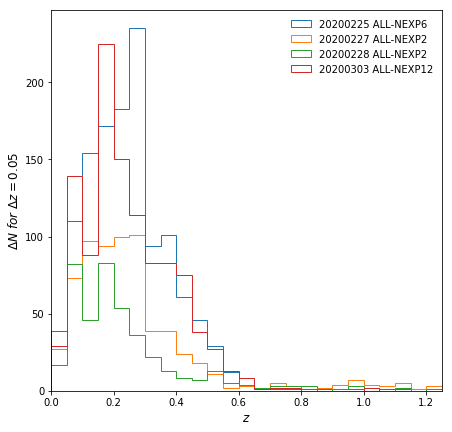

In [431]:
plt.rcParams['figure.figsize'] = [7, 7]

dz = 0.05

for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if key.split('-')[0] != 'ALL':
        continue
    
    if results[tile][night][key] is None:
        continue

    _ = pl.hist(results[tile][night][key]['zbests']['Z'][results[tile][night][key]['IS_ZGOOD_BGS']], bins=np.arange(0.0, 2.0, dz), histtype='step', label=night + ' ' + key)

pl.xlabel(r'$z$', fontsize=12)
pl.ylabel(r'$\Delta N \ for \ \Delta z = {}$'.format(dz), fontsize=12)

pl.legend(loc=1, frameon=False)

pl.xlim(0.0, 1.25)

##  Prospect

In [48]:
tile          = 70500
night         = '20200303'

keep          = results[tile][night]

In [51]:
for key in keep.keys():
 if keep[key] == None:
  continue

 else:
  zbest                       = keep[key]['zbests']
  coadds                      = keep[key]['coadds']
    
  fails                       = keep[key]['zbests']['ZWARN'] > 0  

  # Keep ALL good such that targets are common across keys.
  is_good_bgs                 = keep[key]['IS_GOOD_BGS']
  is_zgood_bgs                = keep[key]['IS_ZGOOD_BGS']
    
  coadds_paths                = keep[key]['coadds_paths']

  zbest                       = Table(zbest)

  targetids                   = zbest['TARGETID']

  for petal in upetals:    
    specfile                  = coadds_paths[petal]
    
    spectra                   = desispec.io.read_spectra(specfile)
    spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
    
    in_petal                  = is_good_bgs & fails & (coadds['PETAL_LOC'] == petal)
    in_petal                  = targetids[in_petal]
    in_petal70                = in_petal[:70]

    print('Generating failures for night {} tile {} key {} and petal {}.  GOOD BGS: {}, ZGOOD_BGS {}'.format(night, tile, key, petal,\
                                                                                                             np.count_nonzero(is_good_bgs & (coadds['PETAL_LOC'] == petal)),\
                                                                                                             np.count_nonzero(is_zgood_bgs & (coadds['PETAL_LOC'] == petal))))
    
    try:
      sp_single_exp           = spectra.select(targets=in_petal70)
 
      plotframes.plotspectra(sp_single_exp, zcatalog=zbest, notebook=False, with_coaddcam=False, with_thumb_tab=False, title='{}_{}_'.format(tile, night) + key + '_' + str(petal) + '_FAILURES', html_dir='/global/homes/m/mjwilson/www/MINISV')
    
    except:
      print('\tNo valid targets were selected}.')
    
    #  Fix permissions.
    os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')
          
print('Done.')

Generating failures for night 20200303 tile 70500 key NEXP1-52932 and petal 0.  GOOD BGS: 234, ZGOOD_BGS 207
Generating failures for night 20200303 tile 70500 key NEXP1-52932 and petal 3.  GOOD BGS: 205, ZGOOD_BGS 174
Generating failures for night 20200303 tile 70500 key NEXP1-52932 and petal 6.  GOOD BGS: 215, ZGOOD_BGS 192
Generating failures for night 20200303 tile 70500 key NEXP1-52932 and petal 7.  GOOD BGS: 215, ZGOOD_BGS 201


/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/plotframes.py:405: RuntimeWarning: All-NaN slice encountered
  ymin = min(ymin, np.nanmin(spectra.flux[band][0]))
/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/plotframes.py:406: RuntimeWarning: All-NaN slice encountered
  ymax = max(ymax, np.nanmax(spectra.flux[band][0]))


Generating failures for night 20200303 tile 70500 key NEXP1-52932 and petal 9.  GOOD BGS: 247, ZGOOD_BGS 210
Generating failures for night 20200303 tile 70500 key NEXP1-52933 and petal 0.  GOOD BGS: 234, ZGOOD_BGS 210
Generating failures for night 20200303 tile 70500 key NEXP1-52933 and petal 3.  GOOD BGS: 205, ZGOOD_BGS 180
Generating failures for night 20200303 tile 70500 key NEXP1-52933 and petal 6.  GOOD BGS: 215, ZGOOD_BGS 199
Generating failures for night 20200303 tile 70500 key NEXP1-52933 and petal 7.  GOOD BGS: 215, ZGOOD_BGS 204
Generating failures for night 20200303 tile 70500 key NEXP1-52933 and petal 9.  GOOD BGS: 247, ZGOOD_BGS 216
Generating failures for night 20200303 tile 70500 key NEXP1-52939 and petal 0.  GOOD BGS: 234, ZGOOD_BGS 208
Generating failures for night 20200303 tile 70500 key NEXP1-52939 and petal 3.  GOOD BGS: 202, ZGOOD_BGS 165
Generating failures for night 20200303 tile 70500 key NEXP1-52939 and petal 6.  GOOD BGS: 213, ZGOOD_BGS 192
Generating failures

##  Define spectral features 

In [432]:
def _airtovac(w):
    """
    Convert air wavelengths to vacuum wavelengths. Don't convert less than 2000 Å.
    
    Parameters
    ----------
    w : :class:`float`
        Wavelength [Å] of the line in air.
    Returns
    -------
    :class:`float`
        Wavelength [Å] of the line in vacuum.
    """
    if w < 2000.0:
      return w;

    vac = w

    for iter in range(2):
        sigma2 = (1.0e4/vac)*(1.0e4/vac)
        fact   = 1.0 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)
        vac    = w * fact
        
    return  vac

In [433]:
##  https://github.com/desihub/prospect/blob/cd445bcf3912d834f17587eff2c28cde6b7fe7a8/py/prospect/plotframes.py#L1214
_line_list = [
#
# This is the set of emission lines from the spZline files.
# See $IDLSPEC2D_DIR/etc/emlines.par
# Wavelengths are in air for lambda > 2000, vacuum for lambda < 2000.
# TODO: convert to vacuum wavelengths
#
    {"name" : "Lyα",      "longname" : "Lyman α",        "lambda" : 1215.67,  "emission": True, "major": True  },
    #{"name" : "Lyβ",      "longname" : "Lyman β",        "lambda" : 1025.18,  "emission": True, "major": False },
    #{"name" : "N V",      "longname" : "N V 1240",       "lambda" : 1240.81,  "emission": True, "major": False },
    #{"name" : "C IV",     "longname" : "C IV 1549",      "lambda" : 1549.48,  "emission": True, "major": True  },
    #{"name" : "He II",    "longname" : "He II 1640",     "lambda" : 1640.42,  "emission": True, "major": False },
    #{"name" : "C III]",   "longname" : "C III] 1908",    "lambda" : 1908.734, "emission": True, "major": False },
    #{"name" : "Mg II",    "longname" : "Mg II 2799",     "lambda" : 2799.49,  "emission": True, "major": False },
    {"name" : "[O II]",   "longname" : "[O II] 3725",    "lambda" : 3726.032, "emission": True, "major": True  },
    {"name" : "[O II]",   "longname" : "[O II] 3727",    "lambda" : 3728.815, "emission": True, "major": True  },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3868",  "lambda" : 3868.76,  "emission": True, "major": False },
    #{"name" : "Hζ",       "longname" : "Balmer ζ",       "lambda" : 3889.049, "emission": True, "major": False },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3970",  "lambda" : 3970.00,  "emission": True, "major": False },
    #{"name" : "Hε",       "longname" : "Balmer ε",       "lambda" : 3970.072, "emission": True, "major": False },
    {"name" : "Hδ",       "longname" : "Balmer δ",       "lambda" : 4101.734, "emission": True, "major": False },
    #{"name" : "Hγ",       "longname" : "Balmer γ",       "lambda" : 4340.464, "emission": True, "major": False },
    {"name" : "[O III]",  "longname" : "[O III] 4363",   "lambda" : 4363.209, "emission": True, "major": False },
    #{"name" : "He II",    "longname" : "He II 4685",     "lambda" : 4685.68,  "emission": True, "major": False },
    {"name" : "Hβ",       "longname" : "Balmer β",       "lambda" : 4861.325, "emission": True, "major": False },
    {"name" : "[O III]",  "longname" : "[O III] 4959",   "lambda" : 4958.911, "emission": True, "major": True },
    {"name" : "[O III]",  "longname" : "[O III] 5007",   "lambda" : 5006.843, "emission": True, "major": True  },
    #{"name" : "He II",    "longname" : "He II 5411",     "lambda" : 5411.52,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 5577",     "lambda" : 5577.339, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 5755",    "lambda" : 5754.59,  "emission": True, "major": False },
    #{"name" : "He I",     "longname" : "He I 5876",      "lambda" : 5875.68,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 6300",     "lambda" : 6300.304, "emission": True, "major": False },
    #{"name" : "[S III]",  "longname" : "[S III] 6312",   "lambda" : 6312.06,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 6363",     "lambda" : 6363.776, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 6548",    "lambda" : 6548.05,  "emission": True, "major": False },
    {"name" : "Hα",       "longname" : "Balmer α",       "lambda" : 6562.801, "emission": True, "major": True  },
    #{"name" : "[N II]",   "longname" : "[N II] 6583",    "lambda" : 6583.45,  "emission": True, "major": False },
    #{"name" : "[S II]",   "longname" : "[S II] 6716",    "lambda" : 6716.44,  "emission": True, "major": False },
    #{"name" : "[S II]",   "longname" : "[S II] 6730",    "lambda" : 6730.82,  "emission": True, "major": False },
    {"name" : "[Ar III]", "longname" : "[Ar III] 7135",  "lambda" : 7135.790, "emission": True, "major": False },
#
# Absorption lines
#
    #{"name" : "Hζ",   "longname" : "Balmer ζ",         "lambda" : 3889.049, "emission": False, "major": False },
    #{"name" : "K",    "longname" : "K (Ca II 3933)",   "lambda" : 3933.7,   "emission": False, "major": False },
    #{"name" : "H",    "longname" : "H (Ca II 3968)",   "lambda" : 3968.5,   "emission": False, "major": False },
    #{"name" : "Hε",   "longname" : "Balmer ε",         "lambda" : 3970.072, "emission": False, "major": False },
    #{"name" : "Hδ",   "longname" : "Balmer δ",         "lambda" : 4101.734, "emission": False, "major": False },
    #{"name" : "G",    "longname" : "G (Ca I 4307)",    "lambda" : 4307.74,  "emission": False, "major": False },
    #{"name" : "Hγ",   "longname" : "Balmer γ",         "lambda" : 4340.464, "emission": False, "major": False },
    #{"name" : "Hβ",   "longname" : "Balmer β",         "lambda" : 4861.325, "emission": False, "major": False },
    #{"name" : "Mg I", "longname" : "Mg I 5175",        "lambda" : 5175.0,   "emission": False, "major": False },
    #{"name" : "D2",   "longname" : "D2 (Na I 5889)",   "lambda" : 5889.95,  "emission": False, "major": False },
    #{"name" : "D1",   "longname" : "D1 (Na I 5895)",   "lambda" : 5895.92,  "emission": False, "major": False },
    #{"name" : "Hα",   "longname" : "Balmer α",         "lambda" : 6562.801, "emission": False, "major": False },
  ]

In [434]:
line_waves = [_airtovac(line['lambda']) for line in _line_list]
line_names = [          line['name']    for line in _line_list]
    
lines      = dict(zip(line_names, line_waves))

pairs      = [comb for comb in combinations(lines, 2)]
pairs      = [(lines[pair[0]], lines[pair[1]]) for pair in pairs]

##  Define summary fig.

In [435]:
def summary(keep, keys):
    fig, axes     = plt.subplots(1, figsize=(10, 10))

    zs            = np.arange(0., 2.0, 0.01)

    # axes.plot(zs, zs, c='k', lw=1.)

    for pair in pairs:
        axes.plot(zs, (1. + zs) * pair[0] / pair[1] - 1.0, c='k', lw=.05)
        axes.plot(zs, (1. + zs) * pair[1] / pair[0] - 1.0, c='k', lw=.05)

    _all          = [x for x in keep.keys() if x[0] == 'A'][0]
    
    for i, key in enumerate(keys):
        assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
        isgood    = keep[_all]['IS_ZGOOD_BGS'] &   keep[key]['IS_ZGOOD_BGS']
        whyfail   = keep[_all]['IS_ZGOOD_BGS'] & (~keep[key]['IS_ZGOOD_BGS'])

        delta_v   = 3.e5 * np.abs(keep[_all]['zbests']['Z'][isgood] - keep[key]['zbests']['Z'][isgood]) / (1. + keep[_all]['zbests']['Z'][isgood])    
        delta_v   = delta_v > 1000.

        im        = axes.scatter(keep[_all]['zbests']['Z'][isgood][delta_v], keep[key]['zbests']['Z'][isgood][delta_v], c=keep[key]['zbests']['DELTACHI2'][isgood][delta_v], marker='x', s=13, vmin=9., vmax=20.)
        im        = axes.scatter(keep[_all]['zbests']['Z'][isgood],          keep[key]['zbests']['Z'][isgood],          c=keep[key]['zbests']['DELTACHI2'][isgood], marker='.', lw=0, s=15, vmin=9., vmax=20.)
        _         = axes.scatter(keep[_all]['zbests']['Z'][whyfail],         keep[key]['zbests']['Z'][whyfail],         c='k', alpha=0.5, marker='.', lw=0, s=15)
        
        moonfrac  = results[tile][night][key]['MOON_FRAC']
        moonalt   = results[tile][night][key]['MOON_ALT']
        exptime   = results[tile][night][key]['EXPTIME']
    
        is_bgs      = results[tile][night][key]['IS_BGS']
        is_good_bgs = results[tile][night][key]['IS_GOOD_BGS']
        is_goodz    = results[tile][night][key]['IS_ZGOOD_BGS'] 
    
    ##
    divider   = make_axes_locatable(axes)
    cax       = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\Delta \chi^2$')
    
    axes.set_xlabel('Z ALL', fontsize=10)
    axes.set_ylabel('{}  Z'.format(key.split('-')[0]), fontsize=10)
    
    axes.set_xlim(0., 1.8)
    axes.set_ylim(0., 1.8)
    
    # axes.legend(frameon=False, loc=4, ncol=5, fontsize=10)

    axes.set_title('NIGHT: {} and TILE {}; MOON FRAC {:.2f} and MOONALT {:.2f} and EXPTIME {:.1f} ({:.2f}% completeness, {:.2f}% cat. fails)\n'.format(night, tile, moonfrac, moonalt, exptime, 100. * np.count_nonzero(is_goodz) / np.count_nonzero(is_good_bgs), 100. * np.count_nonzero(delta_v) / len(delta_v)), fontsize=10)

##  Define delta_v plot 

In [436]:
def deltav_plot(keep, keys, axes=None):
  if axes == None:  
    fig, axes       = plt.subplots(1, figsize=(10, 10))
    
  _all              = [x for x in keep.keys() if x[0] == 'A'][0]
    
  for i, key in enumerate(keys):
    assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    isgood          = keep[_all]['IS_ZGOOD_BGS']
    
    delta_v         = 3.e5 * np.abs(keep[_all]['zbests']['Z'] - keep[key]['zbests']['Z']) / (1. + keep[_all]['zbests']['Z'])
    
    # cat_fail      = (delta_v > 1.e3) & isgood
    # cat_fail_frac = np.count_nonzero(cat_fail) / np.count_nonzero(isgood)
   
    axes.loglog(keep[_all]['zbests']['DELTACHI2'], np.abs(delta_v), marker='.', label=key, lw=0, markersize=1, c='k')

    axes.axhline(1.e3, xmin=0., xmax=1., linestyle='--', c='k', lw=1)
    
    axes.set_xlim(1.e-2, 1.e5)
    axes.set_ylim(1.e-2, 1.e6)
    
    axes.set_xlabel(r'$\Delta \chi^2$', fontsize=12)
    axes.set_ylabel(r'$\Delta v \ [\rm{km}/s]$', fontsize=12)
    
  # axes.legend(frameon=False)

##  Define completeness plot 

In [437]:
def completeness_plot(keep, keys, axes=None, axes_label=''):
  if axes == None:  
    fig, axes       = plt.subplots(1, figsize=(5, 5))
    
  _all              = [x for x in keep.keys() if x[0] == 'A'][0]
    
  for j, key in enumerate(keys):
    assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    is_good          = keep[key]['IS_GOOD_BGS']
    is_zgood         = keep[key]['IS_ZGOOD_BGS']
 
    rflux            = keep[key]['coadds']['FLUX_R'] / keep[key]['coadds']['MW_TRANSMISSION_R']
    rfiberflux       = keep[key]['coadds']['FIBERFLUX_R'] / keep[key]['coadds']['MW_TRANSMISSION_R']
    
    rmag             = flux2mag(rflux)
    rfibmag          = flux2mag(rfiberflux)
    
    dmag             = 0.1
    mag_bins         = np.arange(18.0, 23.5, dmag)
    
    rmag_dig         = np.digitize(rmag,    bins=mag_bins)
    rfibmag_dig      = np.digitize(rfibmag, bins=mag_bins)

    rmag_complete    = []
    rfibmag_complete = []
    
    rmag_valid       = []
    rfibmag_valid    = []
    
    for i, _ in enumerate(mag_bins):
      isin           = (rmag_dig == i)  
        
      if np.count_nonzero(isin & is_good) > 0:           
        rmag_complete.append(100. * np.count_nonzero(isin & is_zgood) / np.count_nonzero(isin & is_good))
        rmag_valid.append(True)
        
      else:
        rmag_complete.append(0.0)
        rmag_valid.append(False)
        
      isin           = (rfibmag_dig == i)
        
      if np.count_nonzero(isin & is_good) > 0: 
        rfibmag_complete.append(100. * np.count_nonzero(isin & is_zgood) / np.count_nonzero(isin & is_good))
        rfibmag_valid.append(True)
    
      else:
        rfibmag_complete.append(0.0)
        rfibmag_valid.append(False)

    rmag_complete    = np.array(rmag_complete)
    rfibmag_complete = np.array(rfibmag_complete)
        
    mag_centers      = mag_bins + dmag / 2.
        
    if j == 0:
        maglabel     = 'Magnitude'
        fibmaglabel  = 'Fiber magnitude'

    else:
        maglabel     = ''
        fibmaglabel  = ''
        
    #  marker='^', lw=0
    axes.plot(mag_centers[rmag_valid],       rmag_complete[rmag_valid],    label=maglabel)
    axes.plot(mag_centers[rfibmag_valid], rfibmag_complete[rfibmag_valid], label=fibmaglabel)

    moonfrac  = results[tile][night][key]['MOON_FRAC']
    moonalt   = results[tile][night][key]['MOON_ALT']
    exptime   = results[tile][night][key]['EXPTIME']
    
    axes.set_title('{}/{}  {:.1f}s; MOON FRAC {:.2f}, MOONALT {:.2f}; {}\n'.format(night, tile, exptime, moonfrac, moonalt, axes_label), fontsize=8)

    break
    
  axes.set_ylim(0., 110.)

  axes.set_xlabel('AB magnitude')
    
  axes.legend(frameon=False)

##  Define $\Delta \chi^2$ plot

In [438]:
def dchi2(keep, keys):
    fig, axes     = plt.subplots(2, figsize=(10, 10))

    _all          = [x for x in keep.keys() if x[0] == 'A'][0]
    
    for i, key in enumerate(keys):
        assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
        isgood    = keep[_all]['IS_ZGOOD_BGS'] &   keep[key]['IS_ZGOOD_BGS']
        whyfail   = keep[_all]['IS_ZGOOD_BGS'] & (~keep[key]['IS_ZGOOD_BGS'])

        delta_v   = 3.e5 * np.abs(keep[_all]['zbests']['Z'][isgood] - keep[key]['zbests']['Z'][isgood]) / (1. + keep[_all]['zbests']['Z'][isgood])    
        delta_v   = delta_v > 1000.

        moonfrac  = results[tile][night][key]['MOON_FRAC']
        moonalt   = results[tile][night][key]['MOON_ALT']
        exptime   = results[tile][night][key]['EXPTIME']
    
        is_bgs    = results[tile][night][key]['IS_BGS']
        is_goodz  = results[tile][night][key]['IS_ZGOOD_BGS'] 

        axes[0].hist(np.log10(keep[_all]['zbests']['DELTACHI2'][is_goodz]), label='ALL', bins=100)
        axes[1].hist(np.log10(keep[ key]['zbests']['DELTACHI2'][is_goodz]), label= key,  bins=100)

        break
        
    axes[0].legend(frameon=False)
    axes[1].legend(frameon=False)
        
        
    axes[0].axvline(x=np.log10(9.0), ymin=0., ymax=1., c='k')
    axes[1].axvline(x=np.log10(9.0), ymin=0., ymax=1., c='k')
    
    axes[1].set_xlabel(r'$\log_{10}(\Delta \chi^2)$')

## Keep Tiles for 20200225.

In [439]:
tile          = 70502
night         = '20200225'

keep          = results[tile][night]

keys          = keep.keys()
keys

odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL-NEXP6'])

In [440]:
ones          = ['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090']
twos          = ['NEXP2-0', 'NEXP2-1']

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_inst

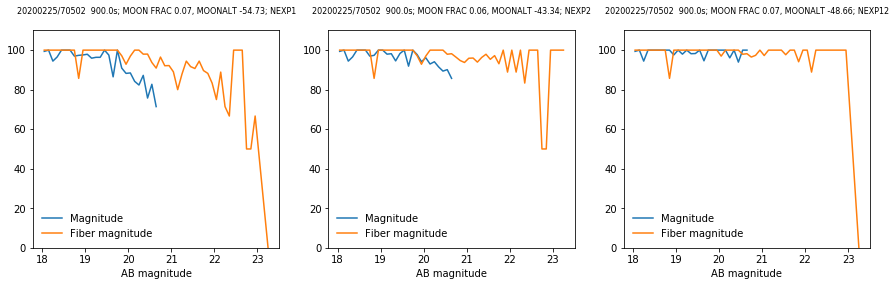

In [441]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

completeness_plot(keep, ones,           axes=axes[0], axes_label='NEXP1')
completeness_plot(keep, twos,           axes=axes[1], axes_label='NEXP2')
completeness_plot(keep, ['ALL-NEXP6'],  axes=axes[2], axes_label='NEXP12')

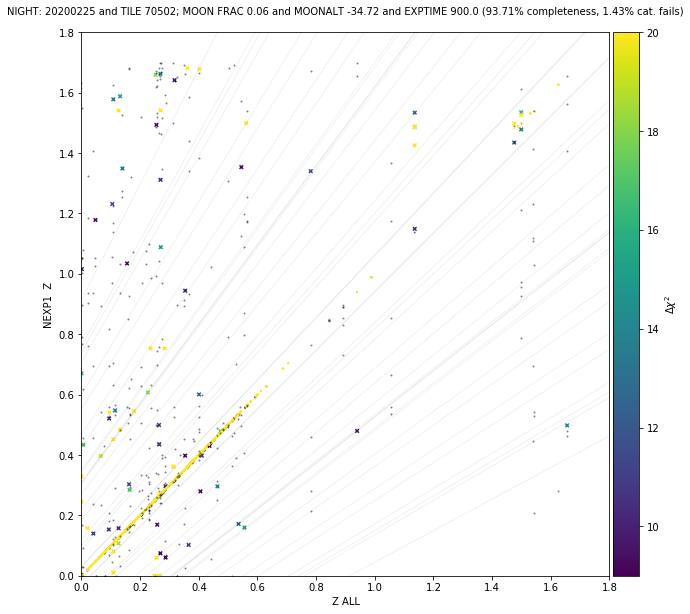

In [442]:
summary(keep, ones)

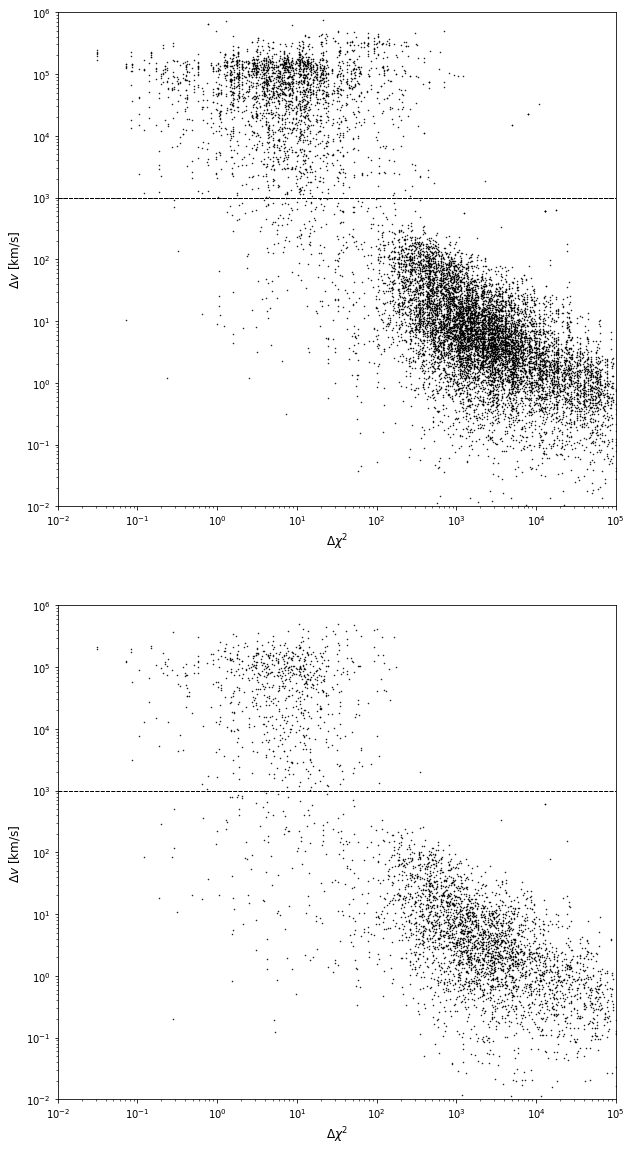

In [443]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20))

deltav_plot(keep, ones, axes[0])
deltav_plot(keep, twos, axes[1])

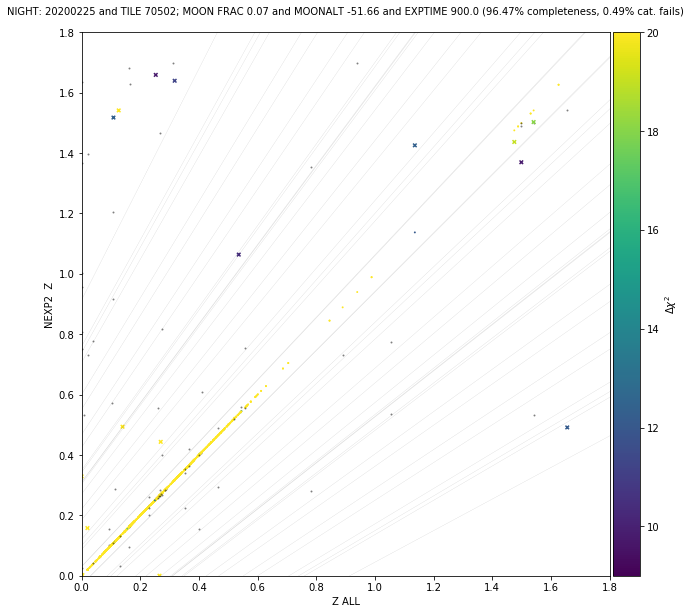

In [444]:
summary(keep, twos)

## 20200227/70502

In [445]:
tile          = 70502
night         = '20200227'

keep          = results[tile][night]

keys          = keep.keys()
keys

odict_keys(['NEXP1-52447', 'NEXP1-52448', 'NEXP4', 'ALL-NEXP2'])

In [446]:
ones          = ['NEXP1-52447', 'NEXP1-52448']
fours         = ['NEXP4']

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_inst

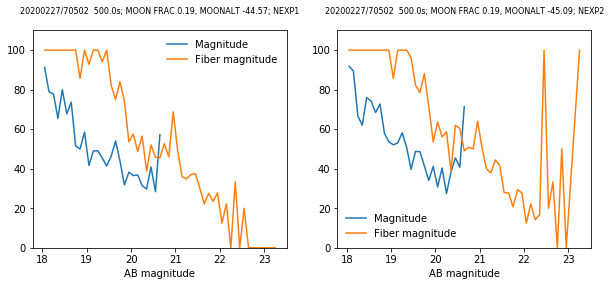

In [447]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

completeness_plot(keep, ones,           axes=axes[0], axes_label='NEXP1')
completeness_plot(keep, ['ALL-NEXP2'],  axes=axes[1], axes_label='NEXP2')

## 20200303/70500

In [448]:
tile          = 70500
night         = '20200303'

keep          = results[tile][night]
keys          = keep.keys()
keys

odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL-NEXP12'])

In [449]:
ones          = ['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936']
twos          = ['NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4']
fours         = ['NEXP4-0', 'NEXP4-1']

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_inst

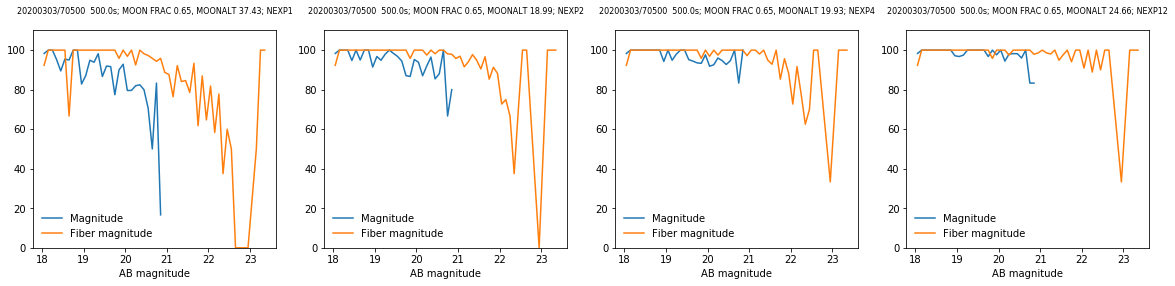

In [450]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

completeness_plot(keep, ones,           axes=axes[0], axes_label='NEXP1')
completeness_plot(keep, twos,           axes=axes[1], axes_label='NEXP2')
completeness_plot(keep, fours,          axes=axes[2], axes_label='NEXP4')
completeness_plot(keep, ['ALL-NEXP12'], axes=axes[3], axes_label='NEXP12')

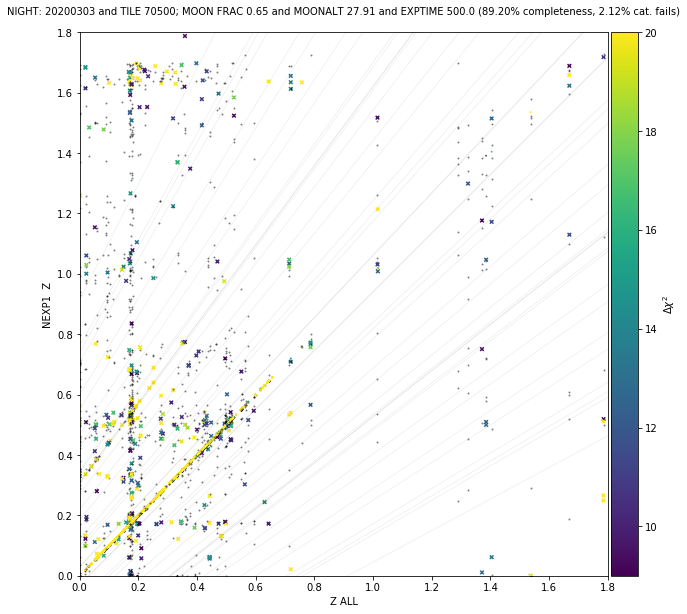

In [451]:
summary(keep, ones)

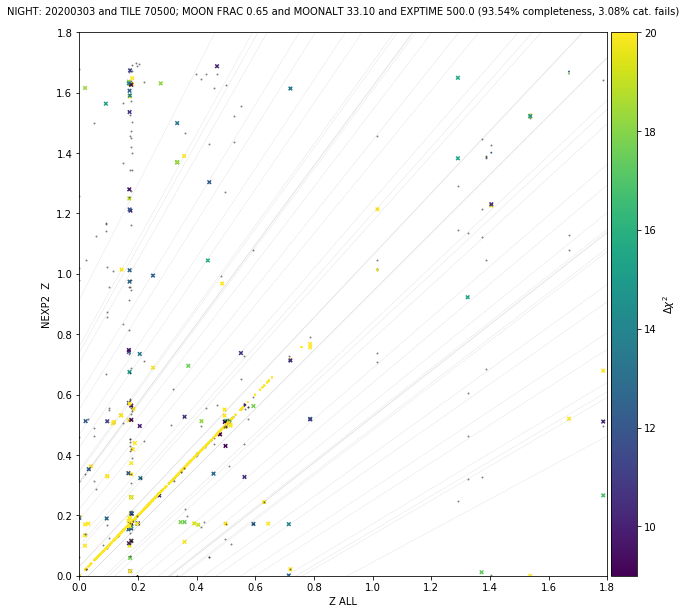

In [452]:
summary(keep, twos)

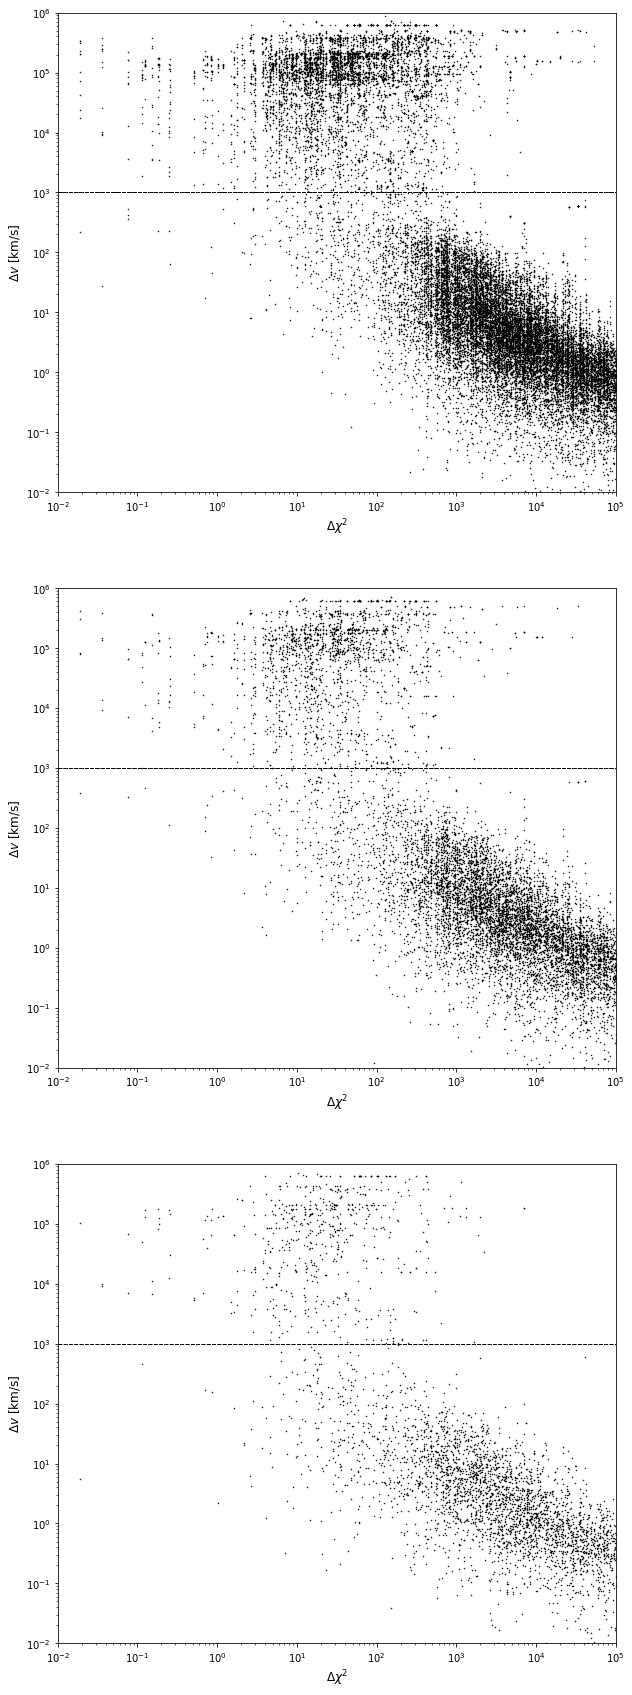

In [453]:
fig, axes = plt.subplots(3, 1, figsize=(10, 30))

deltav_plot(keep, ones,  axes[0])
deltav_plot(keep, twos,  axes[1])
deltav_plot(keep, fours, axes[2])

##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):    
    zbest    = Table(zbests)[i]
    
    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()
    
    fulltype = (spectype, subtype)
    
    # print(z, zerr)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave + 5.,            tflux, lw=1.0)
    # ax.plot( wave,              txflux, lw=1.0)

    ax.legend(loc=2, frameon=False)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

##  Done.